Trying lo load a model

In [58]:
import sys
import logging
import numpy as np
import torch
from sdo.models.autocalibration6 import Autocalibration6
from torch.utils.data import DataLoader
from sdo.datasets.dimmed_sdo_dataset import DimmedSDO_Dataset
from sdo.pytorch_utilities import init_gpu, set_seed
import matplotlib.pyplot as plt

In [59]:
def setup_logging(loglevel, minimal):
    """Setup basic logging

    Args:
      loglevel (int): minimum loglevel for emitting messages
    """
    logformat = "%(message)s" if minimal else "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
    logging.basicConfig(level=loglevel, stream=sys.stdout,
                        format=logformat, datefmt="%Y-%m-%d %H:%M:%S")

setup_logging(logging.INFO, minimal=True)

In [60]:
#path_model = '/gpfs/gpfs_gl4_16mb/b9p111/b9p111aq/pipeline_results/experiments_results/brad_experiment_23/1000_brad_experiment_23_model.pth'
#path_model ='/gpfs/gpfs_gl4_16mb/b9p111/b9p111aq/pipeline_results/experiments_results/mark_autocal_n5_sub4.yaml/0200_mark_autocal_n5_sub4.yaml_model.pth'
#path_model = '/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/experiments_results/throw_away27_128x128_real_data/0050_throw_away27_128x128_real_data_model.pth'
#path_model = '/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/experiments_results/throw_away30_256x256_real_data/0050_throw_away30_256x256_real_data_model.pth'

path_model = '/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/experiments_results/brad_exp_24_0211/0050_brad_exp_24_0211_model.pth'

## Loading the model 

In [61]:
device = init_gpu(cuda_device=1)
torch.cuda.empty_cache()
set_seed()

Using device cuda:1 for training, current device: 0, total devices: 6


In [62]:
num_channels = 1
scaled_height = 256
scaled_width = 256
channels = ['0211']

model = Autocalibration6(input_shape=[num_channels, scaled_height, scaled_width],
                         output_dim=num_channels)
model.eval()
model.cuda(device)

input_channels: 1
cnn_output_dim: 93312


Autocalibration6(
  (_conv2d1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d1_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_conv2d2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d2_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_fc): Linear(in_features=93312, out_features=1, bias=True)
)

In [63]:
state_dict = torch.load(path_model)
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Checking the loaded model works

In [64]:
batch_size_test = 10
tolerance = 0.05

test_dataset = DimmedSDO_Dataset(num_channels,
                                 instr=["AIA"] * num_channels,
                                 channels=channels,
                                 yr_range=[2012, 2013],
                                 mnt_step=1,
                                 day_step=1,
                                 h_step=6,
                                 min_step=60,
                                 resolution=512,
                                 subsample=2,
                                 normalization=0,
                                 scaling=True,
                                 min_alpha=0.01,
                                 scaled_height=scaled_height,
                                 scaled_width=scaled_width,
                                 noise_image=False,
                                 threshold_black=True,
                                 threshold_black_value=0.09,
                                 flip_image=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test)

Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOMLmm"
Training on months "[1 2 3 4 5 6 7]"
Max number of timestamps: 1736
Timestamps found in the inventory: 1636 (0.94)
N timestamps discarded because channel is missing = 0 (0.00000)
Selected timestamps = 1636
N images = 1636


In [65]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.cpu().detach()
    return hook

all_input = []
all_gt_output = []
all_output = []

attention1 = []
attention2 = []

# model._conv2d1.register_forward_hook(get_activation('_conv2d1'))
# model._conv2d1_maxpool.register_forward_hook(get_activation('_conv2d1_maxpool'))
model._conv2d2_maxpool.register_forward_hook(get_activation('_conv2d2_maxpool'))

In [66]:
examples = enumerate(test_loader)
batch_idx, (input_data, gt_output, orig_img) = next(examples)

In [67]:
#for batch_idx, (input_data, gt_output, _) in enumerate(test_loader):
input_data = input_data.to(device)
gt_output = gt_output.to(device)
output = model(input_data)
#print(activation['_conv2d1'].shape)
#print(activation['_conv2d2'].shape)
#plt.imshow(activation['_conv2d1'][0,50,:,:],cmap='seismic')
attention1.append(activation['_conv2d2_maxpool'])



input_data = input_data.cpu().detach().numpy()
output = output.cpu().detach().numpy()
gt_output = gt_output.cpu().detach().numpy()
orig_img = orig_img.cpu().detach().numpy()

all_input.append(input_data)
all_gt_output.append(gt_output)
all_output.append(output)

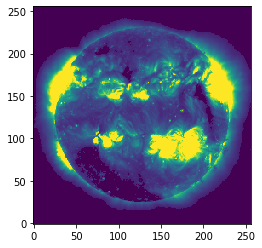

In [68]:
plt.imshow(orig_img[0,0,:,:],vmin=0,vmax=1,origin='lower')

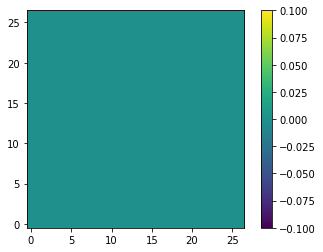

In [69]:
plt.imshow(attention1[0][0,1,:,:],origin='lower')
plt.colorbar()

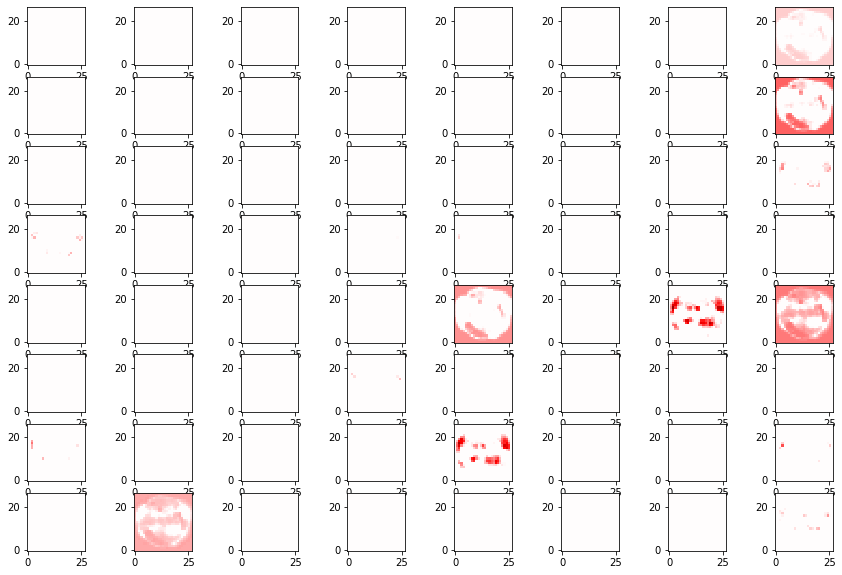

In [70]:
fig, ax = plt.subplots(8, 8, figsize=(15,10))
i = 0
j = 0
m = 0
for m in range(0,64):
    #ax[i][j].set_title(channel_pair)
    ax[i][j].imshow(attention1[0][0,m,:,:],cmap='seismic',origin='lower',vmin=-1,vmax=1)
    #ax[i][j].imshow(compute_correlation(img1, img2), cmap='gray', origin='lower')
    j = j + 1
    m = m + 1
    if j%8 == 0:
        i += 1
        j = 0

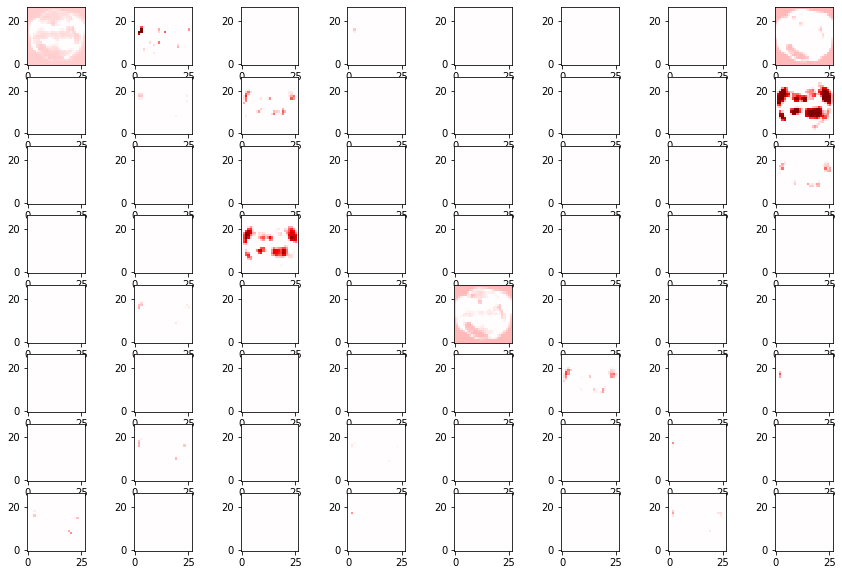

In [71]:
fig, ax = plt.subplots(8, 8, figsize=(15,10))
i = 0
j = 0
m = 0
for m in range(64,128):
    #ax[i][j].set_title(channel_pair)
    ax[i][j].imshow(attention1[0][0,m,:,:],cmap='seismic',origin='lower',vmin=-1,vmax=1)
    #ax[i][j].imshow(compute_correlation(img1, img2), cmap='gray', origin='lower')
    j = j + 1
    m = m + 1
    if j%8 == 0:
        i += 1
        j = 0

In [ ]:
fig, ax = plt.subplots(32, 4, figsize=(15,15))
#fig.subplots_adjust(hspace = 0.18,wspace=0.33,left=0.076,right=0.974,top=0.809,bottom=0.191)
i = 0
j = 0
m = 0
for m in range(0,128):
    #ax[i][j].set_title(channel_pair)
    ax[i][j].imshow(attention2[0][0,m,:,:],cmap='seismic',origin='lower',vmin=-1,vmax=1)
    #ax[i][j].imshow(compute_correlation(img1, img2), cmap='gray', origin='lower')
    j = j + 1
    m = m + 1
    if j%4 == 0
        i += 1
        j = 0

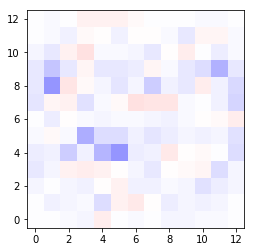

In [36]:
plt.imshow(attention1[0][0,61,:,:],cmap='seismic',vmin=-1, vmax=1,origin='lower')

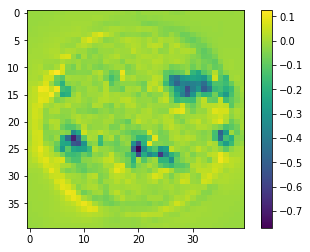

In [51]:
plt.imshow(attention2[2][0,50,:,:])
plt.colorbar()

## Copy blindly from repo

In [7]:
"""
Created on Thu Oct 26 11:23:47 2017
@author: Utku Ozbulak - github.com/utkuozbulak
"""
import torch
from torch.nn import ReLU

from sdo.viz.misc_functions import (get_example_params,
                            convert_to_grayscale,
                            save_gradient_images,
                            get_positive_negative_saliency)


class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class, cnn_layer, filter_pos):
        self.model.zero_grad()
        # Forward pass
        x = input_image
        for index, layer in enumerate(self.model.features):
            # Forward pass layer by layer
            # x is not used after this point because it is only needed to trigger
            # the forward hook function
            x = layer(x)
            # Only need to forward until the selected layer is reached
            if index == cnn_layer:
                # (forward hook function triggered)
                break
        conv_output = torch.sum(torch.abs(x[0, filter_pos]))
        # Backward pass
        conv_output.backward()
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr



In [11]:
if __name__ == '__main__':
    cnn_layer = 10
    filter_pos = 5
    target_example = 2  # Spider
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)

    # File export name
    file_name_to_export = file_name_to_export + '_layer' + str(cnn_layer) + '_filter' + str(filter_pos)
    # Guided backprop
    GBP = GuidedBackprop(model)
    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, target_class, cnn_layer, filter_pos)
    # Save colored gradients
    save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
    # Convert to grayscale
    grayscale_guided_grads = convert_to_grayscale(guided_grads)
    # Save grayscale gradients
    save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
    # Positive and negative saliency maps
    pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
    save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
    save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
    print('Layer Guided backprop completed')

AttributeError: 'Autocalibration1' object has no attribute 'features'